In [1]:
# Load data - run prep_exp.ipynb first
import pickle

pickle_in = open("temp.pkl","rb")
data = pickle.load(pickle_in)

# # If it's not there, do the following:
# import sys
# import os
# import numpy as np
# from str2bool import str2bool
# from rpy2.robjects.packages import STAP
# import rpy2.robjects as robjects
# from rpy2.robjects import pandas2ri, numpy2ri
# from rpy2.robjects.lib.dplyr import DataFrame
# from rpy2.robjects.packages import importr

# pandas2ri.activate()
# numpy2ri.activate()

# # Some temporary arguments for testing
# include_lab = str2bool("T")  # Include lab features?
# include_ethdon = str2bool("T")  # Include ethnicity + donor details?
# lag = int("1")  # Number of lag variables
# eq_train_ratio = str2bool("T")  # Train on equal case:control ratio?
# __file__ = '/h/angeliney/projects/SRTR/prep_exp.py'
# visit_type = "first"
# output = "temp"
# post2000 = True

# # Get features based on these inputs
# with open(os.path.join(os.path.dirname(__file__), 'features.R'), 'r') as f:
#     string = f.read()
# features_file = STAP(string, "features")
# features_to_use = features_file.features.rx2("clin")
# if include_lab:
#     features_to_use = features_to_use + features_file.features.rx2("lab")

# if include_ethdon:
#     features_to_use = features_to_use + features_file.features.rx2("eth") + features_file.features.rx2("don")

# timedep_cols = np.intersect1d(features_to_use, features_file.timedep_features)
# cov_cols = np.setdiff1d(features_to_use, timedep_cols)

# if eq_train_ratio:
#     eq_cases_train_cols = np.array(["TRR_ID", "is_diab"])
# else:
#     eq_cases_train_cols = np.array()
    
# # Read RDS files (load data table)
# readRDS = robjects.r['readRDS']
# tx_li_study = readRDS(os.path.join(os.path.dirname(__file__), 'tx_li_formatted.rds'))
# txf_li_study = readRDS(os.path.join(os.path.dirname(__file__), 'txf_li_formatted.rds'))

# # Merge them
# with open(os.path.join(os.path.dirname(__file__), 'functions.R'), 'r') as f:
#     string = f.read()
# functions = STAP(string, "functions")

# merged = functions.combine_tx_txf(tx_li_study, txf_li_study, np.setdiff1d(cov_cols, "age"), timedep_cols, lag)

# df = pandas2ri.ri2py_dataframe(DataFrame(merged).filter('time_next_followup > time_since_transplant'))

# #Prep data for model training
# cols = np.concatenate((timedep_cols, cov_cols))
# if lag > 0:
#     for l in range(1,  lag + 1):
#         cols = np.append(cols, list(map(lambda x: '{}_{}'.format(x, l), timedep_cols)))

# subset_cols = np.concatenate((['transplant_year', 'TRR_ID', 'age'], cols, ['is_diab', 'time_since_transplant',
#                                                                    'time_next_followup', 'time_to_diab',
#                                                                    'diab_time_since_tx', 'diab_in_1_year',
#                                                                    'diab_now']))
# df = df.dropna(subset=subset_cols)
# df_test = df[(df.transplant_year.astype(int) >= 2011) & (df.time_to_diab >= 0)]
# df_nontest = df[(df.transplant_year.astype(int) < 2011) & (df.time_to_diab >= 0)]

# num_folds = 5
# nontest_y = df_nontest.drop_duplicates(subset=['TRR_ID', 'is_diab']).is_diab
# caret = importr('caret')
# folds = caret.createFolds(nontest_y, num_folds, False)

# data = {'test': df_test, 'train': df_nontest, 'cols': cols, 'eq_cases_train_cols': eq_cases_train_cols,
#             'folds': folds}

# import pickle

# # Save data in case kernel got restarted
# pickle.dump(data, open("temp.pkl", "wb")) 

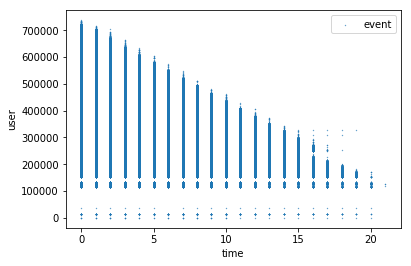

In [2]:
# Prep data
%matplotlib inline
import matplotlib.pyplot as plt
import pandas
import numpy as np


df = pandas.concat([data['train'], data['test']])

# Modify time_since_transplant to accommodate for 0.5 value
def mod_time(x):
    from math import ceil  
    if x == 0:
        return -1
    elif x == 0.5:
        return 0
    elif x % 1 > 0:
        return ceil(x) # To prevent collapse with visit time from beforehand, always round up
    else:
        return x

    
df['time2'] = df.time_since_transplant.apply(mod_time)

# This is different than time since transplant since some people miss albumin, bilirubin, creatinine or acute rej episode at time of transplant
df['t_elapsed'] = df.groupby('TRR_ID', group_keys=False).apply(lambda g : g.time2 - g.time2.min())
df.t_elapsed = df.t_elapsed.astype(int)

# Plot events
plt.scatter(df.t_elapsed, df.TRR_ID, 0.1, label='event')
plt.xlabel('time')
plt.ylabel('user')
plt.legend()


In [3]:
# Subset train, val, test
nontest_ids = data['train'].drop_duplicates(subset=['TRR_ID', 'is_diab']).TRR_ID

i=1
train_ids = nontest_ids[np.array(data['folds']) != i]
val_ids = np.setdiff1d(nontest_ids, train_ids)

train = df[df.TRR_ID.isin(train_ids)]
train = train[train.is_diab == 1]  # Only include censored objects in training. Otherwise, comment out
val = df[df.TRR_ID.isin(val_ids)] 
val = val[val.is_diab == 1]  # Only include censored objects in training. Otherwise, comment out
test = df[df.TRR_ID.isin(data['test'].TRR_ID)] 

#if eq_train_ratio:
#    train = equalize_num_case_control(train, data['eq_cases_train_cols'])

In [4]:
# These are from wtte.transforms but changed, because there's a bug in their versions: id was not ordered 
# and the seq_lengths in df_to_array are not in the same order as unique_ids
def df_to_padded(df, column_names, id_col='id', t_col='t'):
    """Pads pandas df to a numpy array of shape `[n_seqs,max_seqlen,n_features]`.
        see `df_to_array` for details
    """
    return df_to_array(df, column_names, nanpad_right=True, id_col=id_col, t_col=t_col)


def df_to_array(df, column_names, nanpad_right=True, id_col='id', t_col='t'):
    """Converts flat pandas df with cols `id,t,col1,col2,..` to array indexed `[id,t,col]`. 
    :param df: dataframe with columns:
      * `id`: Any type. A unique key for the sequence.
      * `t`: integer. If `t` is a non-contiguous int vec per id then steps in
        between t's are padded with zeros.
      * `columns` in `column_names` (String list)
    :type df: Pandas dataframe
    :param Boolean nanpad_right: If `True`, sequences are `np.nan`-padded to `max_seq_len`
    :param return_lists: Put every tensor in its own subarray
    :param id_col: string column name for `id`
    :param t_col: string column name for `t`
    :return padded: With seqlen the max value of `t` per id
      a numpy float array of dimension `[n_seqs,max_seqlen,n_features]`
    """

    # Do not sort. Create a view.
    grouped = df.groupby(id_col, sort=False)

    unique_ids = list(grouped.groups.keys())

    n_seqs = grouped.ngroups
    n_features = len(column_names)
    seq_lengths = df[[id_col, t_col]].groupby(id_col, as_index=False).aggregate('max')
    seq_lengths[t_col] = seq_lengths[t_col] + 1
    
    # We can't assume to fit varying length seqs. in flat array without
    # padding.
    assert nanpad_right or seq_lengths.shape[0] == 1, 'Wont fit in flat array'

    max_seq_len = seq_lengths[t_col].values.max()

    # Initialize the array to be filled
    padded = np.zeros([n_seqs, max_seq_len, n_features])

    # Fill it
    for s in xrange(n_seqs):
        # df_user is a view
        df_group = grouped.get_group(unique_ids[s])

        padded[s][df_group[t_col].values, :] = df_group[column_names].values
        
        seq_len = seq_lengths[seq_lengths[id_col] == unique_ids[s]][t_col].values[0]
        if nanpad_right and seq_len < max_seq_len:
            padded[s][seq_len:, :].fill(np.nan)

    return padded


/h/angeliney/miniconda2/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


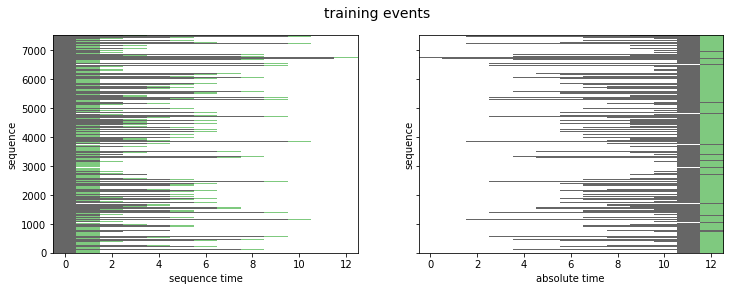

In [5]:
events_train  = df_to_padded(df=train, column_names=['diab_now'], id_col='TRR_ID', t_col='t_elapsed')
x_train       = df_to_padded(df=train, column_names=np.append(data['cols'], 'diab_now'), id_col='TRR_ID', t_col='t_elapsed')

from wtte.plots.misc import timeline_plot
timeline_plot(np.squeeze(events_train), 'training events', cmap='Accent_r');

In [6]:
events_val  = df_to_padded(df=val, column_names=['is_diab'], id_col='TRR_ID', t_col='t_elapsed')
x_val       = df_to_padded(df=val, column_names=np.append(data['cols'], 'is_diab'), id_col='TRR_ID', t_col='t_elapsed')
events_test  = df_to_padded(df=test, column_names=['is_diab'], id_col='TRR_ID', t_col='t_elapsed')
x_test       = df_to_padded(df=test, column_names=np.append(data['cols'], 'is_diab'), id_col='TRR_ID', t_col='t_elapsed')

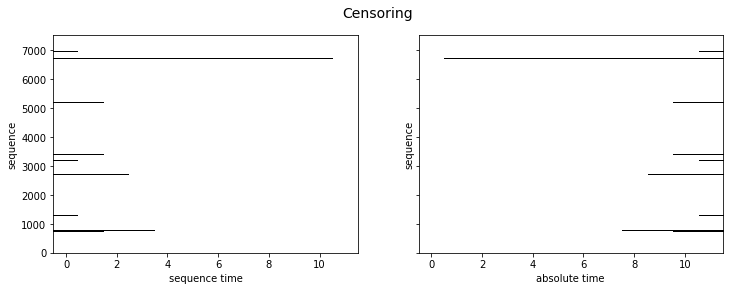

('mean uncensored (train): ', 0.9446560801266961)
('mean uncensored (test) : ', 0.07710848337522146)
('mean tte (test):         ', 2.0801367887602487)
('max  tte (test):         ', 6.0)


In [7]:
from wtte.transforms import padded_events_to_tte, padded_events_to_not_censored

def prep_tensors(x,events):
    # 0. calculate time to event and censoring indicators.
    y  = np.copy(np.concatenate([events,events],-1))
    y[:,:,0] = padded_events_to_tte(np.squeeze(events),discrete_time=True)
    y[:,:,1] = padded_events_to_not_censored(np.squeeze(events),discrete_time=True)

    # 1. Disalign features and targets otherwise truth is leaked.
    # 2. drop first timestep (that we now dont have features for)
    # 3. nan-mask the last timestep of features. (that we now don't have targets for)
    events = events[:,1:,]
    y  = y[:,1:]
    x  = np.roll(x, shift=1, axis=1)[:,1:,]
    x  = x + 0*events
    return x,y,events
    
    
x_train, y_train, events_train = prep_tensors(x_train, events_train)
x_val, y_val, events_val = prep_tensors(x_val, events_val)
x_test, y_test, events_test = prep_tensors(x_test, events_test)

timeline_plot(1-y_train[:,:,1],'Censoring',cmap='Greys');
plt.show()

print('mean uncensored (train): ',np.nanmean(y_train[:,:,1]))
print('mean uncensored (test) : ',np.nanmean(y_test[:,:,1]))
print('mean tte (test):         ',np.nanmean(y_test[:,:,0]))
print('max  tte (test):         ',np.nanmax(y_test[:,:,0]))

In [8]:
def nanmask_to_keras_mask(x, y, mask_value, tte_mask):
    """nanmask to keras mask.
        :param float mask_value: Use some improbable telltale value 
                                (but not nan-causing)
        :param float tte_mask: something that wont NaN the loss-function
    """
    # Use some improbable telltale value (but not nan-causing)
    x[:,:,:][np.isnan(x)] = mask_value
    y[:,:,0][np.isnan(y[:,:,0])] = tte_mask
    y[:,:,1][np.isnan(y[:,:,1])] = 0.95
    sample_weights = (x[:,:,0] != mask_value) * 1.
    return x, y, sample_weights

tte_mean_train = np.nanmean(y_train[:,:,0])
mask_value = -1.3371337 
mean_u = np.nanmean(y_train[:,:,1])

x_train, y_train, sample_weights_train = nanmask_to_keras_mask(x_train, y_train, mask_value, tte_mean_train)
x_val, y_val, sample_weights_val = nanmask_to_keras_mask(x_val, y_val,mask_value, tte_mean_train)
x_test, y_test, sample_weights_test = nanmask_to_keras_mask(x_test, y_test, mask_value, tte_mean_train)
 
# Initialization value for alpha-bias 
init_alpha = -1.0/np.log(1.0-1.0/(tte_mean_train+1.0) )
init_alpha = init_alpha/mean_u
print('init_alpha: ',init_alpha,'mean uncensored train: ',mean_u)

('init_alpha: ', 2.6981239744100085, 'mean uncensored train: ', 0.9446560801266961)


In [9]:
import keras.backend as K
from keras.models import Sequential

from keras.layers import Dense, LSTM, GRU, RNN, Masking, Lambda
from keras.layers.wrappers import TimeDistributed

from keras.optimizers import RMSprop,adam
from keras import callbacks

import wtte.weibull as weibull
import wtte.wtte as wtte
from wtte.wtte import WeightWatcher

reduce_lr = callbacks.ReduceLROnPlateau(monitor='loss', 
                                        factor  =0.5, 
                                        patience=50, 
                                        verbose=0, 
                                        mode='auto', 
                                        epsilon=0.0001, 
                                        cooldown=0, 
                                        min_lr=1e-8)

nanterminator = callbacks.TerminateOnNaN()
history = callbacks.History()
weightwatcher = WeightWatcher(per_batch =False, per_epoch= True)
n_features = x_train.shape[-1]

def base_model():
    model = Sequential()
    model.add(Masking(mask_value=mask_value, input_shape=(None, n_features)))
    model.add(GRU(32, activation='tanh', return_sequences=True))
    return model


def wtte_rnn():
    model = base_model()

    #model.add(TimeDistributed(Dense(2)))
    model.add(Dense(2))
    model.add(Lambda(wtte.output_lambda, 
                     arguments={"init_alpha": init_alpha, 
                                "max_beta_value": 4.0,
                                "alpha_kernel_scalefactor": 0.5}))

    loss = wtte.loss(kind='continuous', reduce_loss=False).loss_function
    model.compile(loss=loss, optimizer=adam(lr=.01, clipvalue=0.5), sample_weight_mode='temporal')
    return model

Using TensorFlow backend.
/h/angeliney/miniconda2/lib/python2.7/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, None, 69)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, None, 32)          9792      
_________________________________________________________________
dense_1 (Dense)              (None, None, 2)           66        
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 2)           0         
Total params: 9,858
Trainable params: 9,858
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.


/h/angeliney/miniconda2/lib/python2.7/site-packages/wtte/wtte.py:89: UserWarning: `alpha_kernel_scalefactor` deprecated in favor of `scalefactor` scaling both.
 Setting `scalefactor = alpha_kernel_scalefactor`
  warnings.warn(message)


Train on 7518 samples, validate on 1831 samples
Epoch 1/500
7518/7518 [==============================] - 2s 212us/step - loss: 3.2756 - val_loss: 4.7657
Epoch 2/500
7518/7518 [==============================] - 1s 131us/step - loss: 3.2268 - val_loss: 4.6606
Epoch 3/500
7518/7518 [==============================] - 1s 124us/step - loss: 3.2263 - val_loss: 4.6660
Epoch 4/500
7518/7518 [==============================] - 1s 122us/step - loss: 3.2255 - val_loss: 4.7234
Epoch 5/500
7518/7518 [==============================] - 1s 129us/step - loss: 3.2234 - val_loss: 4.7644
Epoch 6/500
7518/7518 [==============================] - 1s 129us/step - loss: 3.2246 - val_loss: 4.7592
Epoch 7/500
7518/7518 [==============================] - 1s 121us/step - loss: 3.2244 - val_loss: 4.8197
Epoch 8/500
7518/7518 [==============================] - 1s 126us/step - loss: 3.2254 - val_loss: 4.6665
Epoch 9/500
7518/7518 [==============================] - 1s 125us/step - loss: 3.2249 - val_loss: 4.8305
Epoch 1

Epoch 78/500
7518/7518 [==============================] - 1s 123us/step - loss: 3.2248 - val_loss: 4.7771
Epoch 79/500
7518/7518 [==============================] - 1s 126us/step - loss: 3.2233 - val_loss: 4.7844
Epoch 80/500
7518/7518 [==============================] - 1s 123us/step - loss: 3.2241 - val_loss: 4.7879
Epoch 81/500
7518/7518 [==============================] - 1s 123us/step - loss: 3.2257 - val_loss: 4.6675
Epoch 82/500
7518/7518 [==============================] - 1s 119us/step - loss: 3.2220 - val_loss: 4.5683
Epoch 83/500
7518/7518 [==============================] - 1s 123us/step - loss: 3.2239 - val_loss: 4.6059
Epoch 84/500
7518/7518 [==============================] - 1s 124us/step - loss: 3.2239 - val_loss: 4.7045
Epoch 85/500
7518/7518 [==============================] - 1s 123us/step - loss: 3.2241 - val_loss: 4.7756
Epoch 86/500
7518/7518 [==============================] - 1s 126us/step - loss: 3.2251 - val_loss: 4.7408
Epoch 87/500
7518/7518 [======================

Epoch 155/500
7518/7518 [==============================] - 1s 123us/step - loss: 3.2237 - val_loss: 4.6899
Epoch 156/500
7518/7518 [==============================] - 3s 448us/step - loss: 3.2218 - val_loss: 4.7357
Epoch 157/500
7518/7518 [==============================] - 6s 760us/step - loss: 3.2224 - val_loss: 4.7646
Epoch 158/500
7518/7518 [==============================] - 1s 188us/step - loss: 3.2230 - val_loss: 4.6584
Epoch 159/500
7518/7518 [==============================] - 1s 124us/step - loss: 3.2237 - val_loss: 4.6664
Epoch 160/500
7518/7518 [==============================] - 1s 130us/step - loss: 3.2245 - val_loss: 4.6837
Epoch 161/500
7518/7518 [==============================] - 1s 131us/step - loss: 3.2242 - val_loss: 4.6742
Epoch 162/500
7518/7518 [==============================] - 1s 123us/step - loss: 3.2224 - val_loss: 4.7003
Epoch 163/500
7518/7518 [==============================] - 1s 124us/step - loss: 3.2232 - val_loss: 4.6691
Epoch 164/500
7518/7518 [============

7518/7518 [==============================] - 1s 121us/step - loss: 3.2227 - val_loss: 4.6954
Epoch 232/500
7518/7518 [==============================] - 1s 122us/step - loss: 3.2230 - val_loss: 4.7124
Epoch 233/500
7518/7518 [==============================] - 1s 131us/step - loss: 3.2222 - val_loss: 4.7115
Epoch 234/500
7518/7518 [==============================] - 1s 131us/step - loss: 3.2244 - val_loss: 4.6708
Epoch 235/500
7518/7518 [==============================] - 1s 120us/step - loss: 3.2225 - val_loss: 4.7156
Epoch 236/500
7518/7518 [==============================] - 1s 122us/step - loss: 3.2235 - val_loss: 4.7044
Epoch 237/500
7518/7518 [==============================] - 1s 119us/step - loss: 3.2228 - val_loss: 4.6872
Epoch 238/500
7518/7518 [==============================] - 1s 122us/step - loss: 3.2232 - val_loss: 4.6260
Epoch 239/500
7518/7518 [==============================] - 1s 120us/step - loss: 3.2228 - val_loss: 4.6804
Epoch 240/500
7518/7518 [==========================

7518/7518 [==============================] - 1s 167us/step - loss: 3.2227 - val_loss: 4.7067
Epoch 308/500
7518/7518 [==============================] - 1s 169us/step - loss: 3.2231 - val_loss: 4.6876
Epoch 309/500
7518/7518 [==============================] - 1s 175us/step - loss: 3.2226 - val_loss: 4.6836
Epoch 310/500
7518/7518 [==============================] - 1s 169us/step - loss: 3.2222 - val_loss: 4.6801
Epoch 311/500
7518/7518 [==============================] - 1s 169us/step - loss: 3.2236 - val_loss: 4.6914
Epoch 312/500
7518/7518 [==============================] - 1s 167us/step - loss: 3.2218 - val_loss: 4.7027
Epoch 313/500
7518/7518 [==============================] - 1s 168us/step - loss: 3.2237 - val_loss: 4.6920
Epoch 314/500
7518/7518 [==============================] - 1s 172us/step - loss: 3.2230 - val_loss: 4.7002
Epoch 315/500
7518/7518 [==============================] - 1s 136us/step - loss: 3.2225 - val_loss: 4.6963
Epoch 316/500
7518/7518 [==========================

7518/7518 [==============================] - 1s 119us/step - loss: 3.2224 - val_loss: 4.6987
Epoch 384/500
7518/7518 [==============================] - 1s 123us/step - loss: 3.2222 - val_loss: 4.6954
Epoch 385/500
7518/7518 [==============================] - 1s 110us/step - loss: 3.2226 - val_loss: 4.6967
Epoch 386/500
7518/7518 [==============================] - 1s 119us/step - loss: 3.2239 - val_loss: 4.6989
Epoch 387/500
7518/7518 [==============================] - 1s 115us/step - loss: 3.2226 - val_loss: 4.6979
Epoch 388/500
7518/7518 [==============================] - 1s 117us/step - loss: 3.2221 - val_loss: 4.6981
Epoch 389/500
7518/7518 [==============================] - 1s 118us/step - loss: 3.2232 - val_loss: 4.6934
Epoch 390/500
7518/7518 [==============================] - 1s 117us/step - loss: 3.2220 - val_loss: 4.6905
Epoch 391/500
7518/7518 [==============================] - 1s 118us/step - loss: 3.2222 - val_loss: 4.6901
Epoch 392/500
7518/7518 [==========================

7518/7518 [==============================] - 1s 124us/step - loss: 3.2228 - val_loss: 4.6947
Epoch 460/500
7518/7518 [==============================] - 1s 116us/step - loss: 3.2237 - val_loss: 4.6963
Epoch 461/500
7518/7518 [==============================] - 1s 116us/step - loss: 3.2219 - val_loss: 4.6944
Epoch 462/500
7518/7518 [==============================] - 1s 129us/step - loss: 3.2241 - val_loss: 4.6941
Epoch 463/500
7518/7518 [==============================] - 1s 117us/step - loss: 3.2217 - val_loss: 4.6954
Epoch 464/500
7518/7518 [==============================] - 1s 118us/step - loss: 3.2219 - val_loss: 4.6967
Epoch 465/500
7518/7518 [==============================] - 1s 113us/step - loss: 3.2225 - val_loss: 4.6958
Epoch 466/500
7518/7518 [==============================] - 1s 111us/step - loss: 3.2244 - val_loss: 4.6952
Epoch 467/500
7518/7518 [==============================] - 1s 119us/step - loss: 3.2222 - val_loss: 4.6950
Epoch 468/500
7518/7518 [==========================

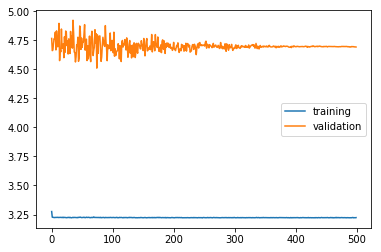

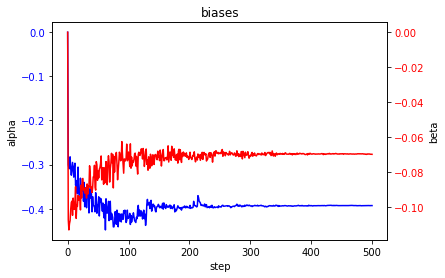

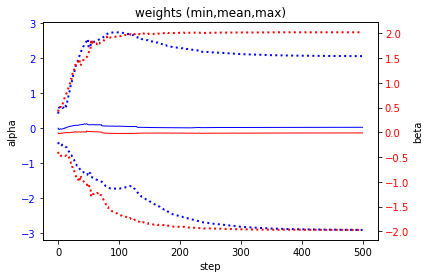

In [10]:
model = wtte_rnn()
model.summary()

K.set_value(model.optimizer.lr, 0.01)
model.fit(x_train, y_train,
          epochs=500,
          batch_size=100, 
          verbose=1,
          validation_data=(x_val, y_val, sample_weights_val),
          sample_weight = sample_weights_train,
          callbacks=[nanterminator, history, weightwatcher, reduce_lr])

plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()
weightwatcher.plot()

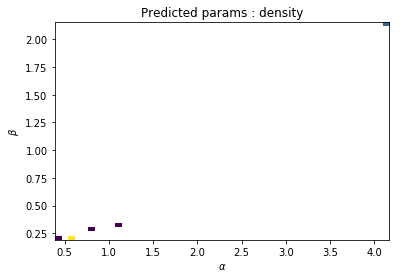

/h/angeliney/miniconda2/lib/python2.7/site-packages/wtte/weibull.py:76: RuntimeWarning: invalid value encountered in power
  mode = a * np.power((b - 1.0) / b, 1.0 / b)


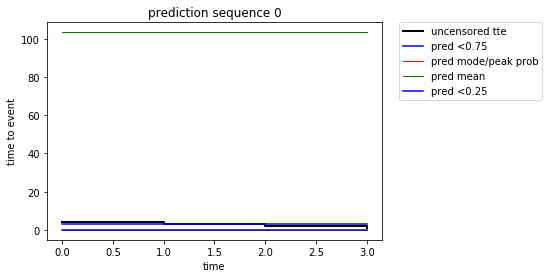

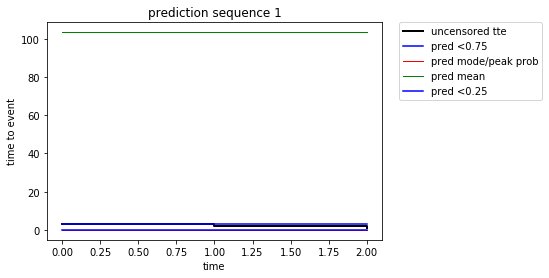

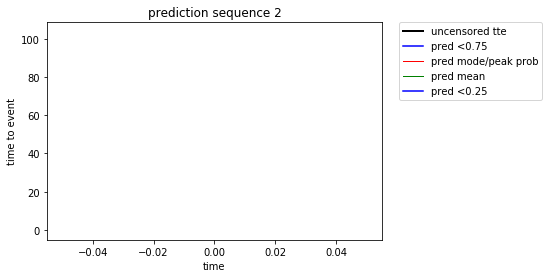

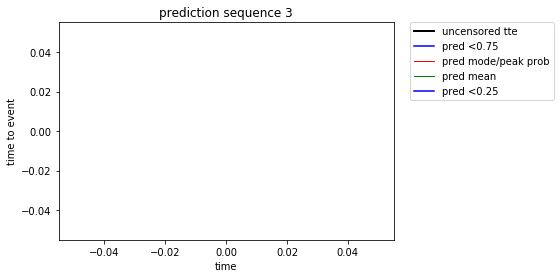

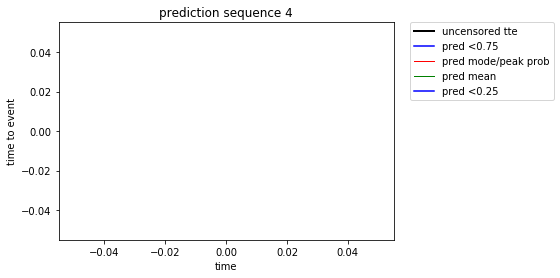

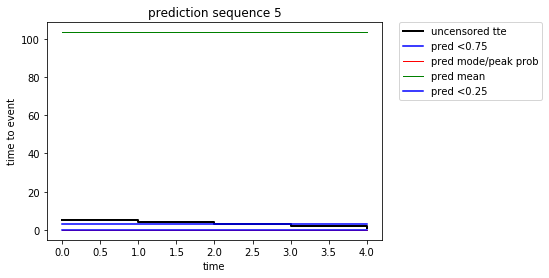

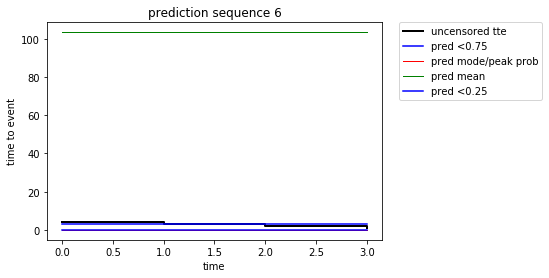

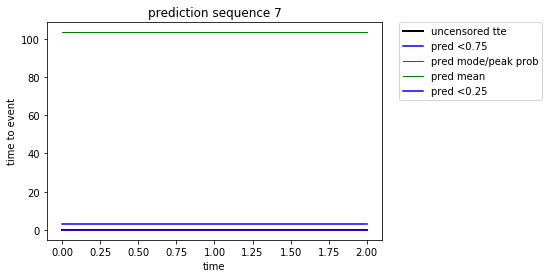

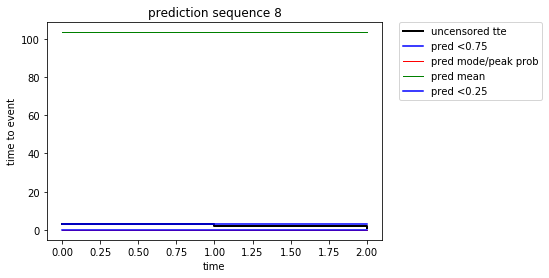

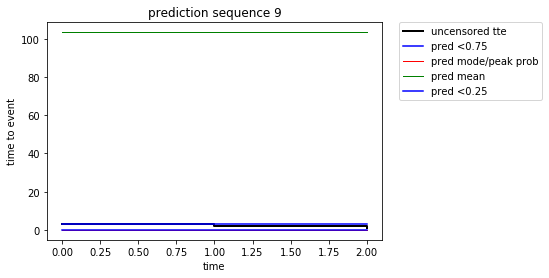

('alpha : mean   ', 0.5635849237251692)
('alpha : median ', 0.5605222582817078)
('alpha :    min ', 0.38695868849754333)
('alpha :    max ', 4.171169757843018)
('beta  : mean   ', 0.1921799812631826)
('beta  : median ', 0.19051611423492432)
('beta  :    min ', 0.19051611423492432)
('beta  :    max ', 2.154294490814209)


In [11]:
# Optional: add a margin of zeros at the end of the sequence to see what the 
# model does after the first events (if it identifies death by pushing prediction to inf)

mask = np.copy(x_test)
mask[mask==mask_value] = np.nan
mask = mask*0
predicted = model.predict(x_test)+mask[:,:,:1]

alpha_flat = predicted[:,:,0][~np.isnan(predicted[:,:,0])].flatten()
beta_flat  = predicted[:,:,1][~np.isnan(predicted[:,:,0])].flatten()

## log-alpha typically makes more sense.
from matplotlib.colors import LogNorm
counts, xedges, yedges, _ = plt.hist2d(alpha_flat, beta_flat, bins=50,norm=LogNorm())
plt.title('Predicted params : density')
plt.xlim([alpha_flat.min(),alpha_flat.max()])
plt.ylim([beta_flat.min(),beta_flat.max()])
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.show()

# Pick out prediction for one sequence
for batch_indx in range(10):
    seq_len = (~np.isnan(predicted[batch_indx,:,0])).sum()
    a = predicted[batch_indx,:seq_len,0]+mask[batch_indx,:seq_len,0]
    b = predicted[batch_indx,:seq_len,1]+mask[batch_indx,:seq_len,0]
    t = np.array(xrange(len(a)))+mask[batch_indx,:seq_len,0]

    tte_actual   = y_test[batch_indx,:seq_len,0]+mask[batch_indx,:seq_len,0]

    ##### Prediction (Using weibull-quantities like quantiles etc)
    drawstyle = 'steps-post'
    plt.plot(t,tte_actual,label='uncensored tte',color='black',linestyle='solid',linewidth=2,drawstyle=drawstyle)

    plt.plot(weibull.quantiles(a,b,0.75),color='blue',label='pred <0.75',drawstyle=drawstyle)
    plt.plot(weibull.mode(a, b), color='red',linewidth=1,label='pred mode/peak prob',drawstyle=drawstyle)
    plt.plot(weibull.mean(a, b), color='green',linewidth=1,label='pred mean',drawstyle='steps-post')
    plt.plot(weibull.quantiles(a,b,0.25),color='blue',label='pred <0.25',drawstyle=drawstyle)

    #     plt.ylim(0, 2*np.nanmax(tte_actual))
    plt.xlabel('time')
    plt.ylabel('time to event')
    plt.title('prediction sequence '+str(batch_indx),)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

print('alpha : mean   ',alpha_flat.mean())
print('alpha : median ',np.median(alpha_flat))
print('alpha :    min ',alpha_flat.min())
print('alpha :    max ',alpha_flat.max())
print('beta  : mean   ',beta_flat.mean())
print('beta  : median ',np.median(beta_flat))
print('beta  :    min ',beta_flat.min())
print('beta  :    max ',beta_flat.max())

In [12]:
from sklearn import metrics
def binned_prob(label, prob, K=10):
    a = -1
    predicted = []
    expected = []
    frac_in_bin = []
    for i in range(K):
        b = (i + 1) / K
        in_interval = ((a < prob) * (prob <= b)) > 0
        if in_interval.any():
            expected.append(label[in_interval].mean())
            predicted.append(prob[in_interval].mean())
        else:
            expected.append(0)
            predicted.append(0)
        a = b
        frac_in_bin.append(in_interval.mean())
    expected, predicted, frac_in_bin = [np.array(arr) for arr in [expected, predicted, frac_in_bin]]
    return expected, predicted, frac_in_bin

def expected_calibration_error(label, prob, K=10):
    # See https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4410090/
    expected,predicted,frac_in_bin = binned_prob(label, prob, K)
    return (frac_in_bin * np.abs(expected - predicted)).sum()

aucs = []
eces = []
box_widths = []

max_box_width = y_test.shape[1]

from wtte.transforms import right_pad_to_left_pad
predicted_tmp = right_pad_to_left_pad(predicted)
tte_tmp = right_pad_to_left_pad(y_test[..., 0])


('box width\t', 0, '\t auc:', 0.5, '\t ECE:', 0.6562, '\t(%in_box:', 0.0164, '\t', 244, ' obs)')
('box width\t', 1, '\t auc:', 0.5, '\t ECE:', 0.704, '\t(%in_box:', 0.0164, '\t', 244, ' obs)')
('box width\t', 2, '\t auc:', 0.5, '\t ECE:', 0.7312, '\t(%in_box:', 0.0164, '\t', 244, ' obs)')
('box width\t', 3, '\t auc:', 0.5, '\t ECE:', 0.75, '\t(%in_box:', 0.0164, '\t', 244, ' obs)')
('box width\t', 4, '\t auc:', 0.5, '\t ECE:', 0.7643, '\t(%in_box:', 0.0164, '\t', 244, ' obs)')
('box width\t', 5, '\t auc:', 0.5, '\t ECE:', 0.7757, '\t(%in_box:', 0.0164, '\t', 244, ' obs)')


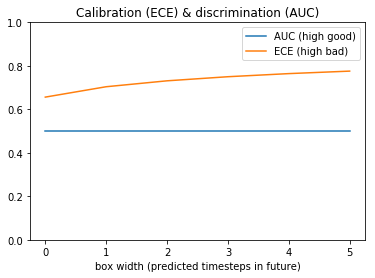

In [13]:
alpha      = predicted_tmp[:, 0, 0]
beta       = predicted_tmp[:, 0, 1]
tte        = tte_tmp[:, 0]
m = ~np.isnan(tte + alpha + beta) # nan-mask

for box_width in xrange(max_box_width):
    if m.sum()==0:
        break
    is_in_box = (tte<=box_width)[m].flatten()
    pred_prob_in_box   = weibull.cmf(a=alpha[m],b=beta[m],t=box_width).flatten()

    ece = expected_calibration_error(is_in_box,pred_prob_in_box)
    fpr,tpr,thresholds = metrics.roc_curve(is_in_box,pred_prob_in_box)
    auc = metrics.auc(fpr,tpr)
    print('box width\t',box_width,'\t auc:',round(auc,4),'\t ECE:',round(ece,4),'\t(%in_box:',round(is_in_box.mean(),4),'\t',m.sum(),' obs)')
    aucs.append(auc)
    eces.append(ece)
    box_widths.append(box_width)
        
plt.plot(box_widths,aucs,label='AUC (high good)')
plt.plot(box_widths,eces,label ='ECE (high bad)')
plt.ylim(0,1)
plt.legend()
plt.xlabel('box width (predicted timesteps in future)')
plt.title('Calibration (ECE) & discrimination (AUC)')
plt.show()

('box width\t', 0, '\t auc:', 0.5, '\t ECE:', 0.2799, '\t(%in_box:', 0.3927, '\t', 7326, ' obs)')
('box width\t', 1, '\t auc:', 0.5, '\t ECE:', 0.2176, '\t(%in_box:', 0.5027, '\t', 7326, ' obs)')
('box width\t', 2, '\t auc:', 0.5, '\t ECE:', 0.1433, '\t(%in_box:', 0.6043, '\t', 7326, ' obs)')
('box width\t', 3, '\t auc:', 0.5, '\t ECE:', 0.0611, '\t(%in_box:', 0.7053, '\t', 7326, ' obs)')
('box width\t', 4, '\t auc:', 0.5, '\t ECE:', 0.0252, '\t(%in_box:', 0.8059, '\t', 7326, ' obs)')
('box width\t', 5, '\t auc:', 0.5, '\t ECE:', 0.0961, '\t(%in_box:', 0.8882, '\t', 7326, ' obs)')
('box width\t', 6, '\t auc:', 0.5, '\t ECE:', 0.1281, '\t(%in_box:', 0.9297, '\t', 7326, ' obs)')
('box width\t', 7, '\t auc:', 0.5, '\t ECE:', 0.1515, '\t(%in_box:', 0.9612, '\t', 7326, ' obs)')
('box width\t', 8, '\t auc:', 0.5, '\t ECE:', 0.1662, '\t(%in_box:', 0.9829, '\t', 7326, ' obs)')
('box width\t', 9, '\t auc:', 0.5, '\t ECE:', 0.1714, '\t(%in_box:', 0.9944, '\t', 7326, ' obs)')
('box width\t', 10, 

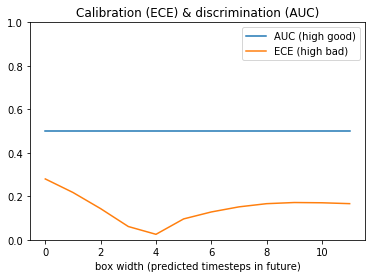

In [14]:
# Train accuracy
mask = np.copy(x_train)
mask[mask==mask_value] = np.nan
mask = mask*0
predicted = model.predict(x_train)+mask[:,:,:1]

alpha_flat = predicted[:,:,0][~np.isnan(predicted[:,:,0])].flatten()
beta_flat  = predicted[:,:,1][~np.isnan(predicted[:,:,0])].flatten()

aucs = []
eces = []
box_widths = []

max_box_width = y_train.shape[1]

predicted_tmp = predicted #right_pad_to_left_pad(predicted)
tte_tmp = y_train[..., 0] #right_pad_to_left_pad(y_train[..., 0])

alpha      = predicted_tmp[:, 0, 0]
beta       = predicted_tmp[:, 0, 1]
tte        = tte_tmp[:, 0]
m = ~np.isnan(tte + alpha + beta) # nan-mask

for box_width in xrange(max_box_width):
    if m.sum()==0:
        break
    is_in_box = (tte<=box_width)[m].flatten()
    pred_prob_in_box   = weibull.cmf(a=alpha[m],b=beta[m],t=box_width).flatten()

    ece = expected_calibration_error(is_in_box,pred_prob_in_box)
    fpr,tpr,thresholds = metrics.roc_curve(is_in_box,pred_prob_in_box)
    auc = metrics.auc(fpr,tpr)
    print('box width\t',box_width,'\t auc:',round(auc,4),'\t ECE:',round(ece,4),'\t(%in_box:',round(is_in_box.mean(),4),'\t',m.sum(),' obs)')
    aucs.append(auc)
    eces.append(ece)
    box_widths.append(box_width)
        
plt.plot(box_widths,aucs,label='AUC (high good)')
plt.plot(box_widths,eces,label ='ECE (high bad)')
plt.ylim(0,1)
plt.legend()
plt.xlabel('box width (predicted timesteps in future)')
plt.title('Calibration (ECE) & discrimination (AUC)')
plt.show()